# 数据预处理 & 特征工程

## Import

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.sans-serif'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False

In [14]:
fp = 'scrapy\LianJiaSpider\data.csv'
raw_data = pd.read_csv(fp)
raw_data.head()

,area,building,direction,elevator,floor,garden,heating,_id,layout,region,renovation,stairway,structure,totalPrice,type,unitPrice,usage,year
0,93.00,板塔结合,南,有,高楼层 (共30层),长安,集中供暖,101117686545,3室2厅1厨1卫,长安,其他,两梯四户,钢混结构,165.0,NaN,17742.0,普通住宅,NaN
1,129.00,板塔结合,南 北,有,中楼层 (共33层),长安,集中供暖,101117686563,3室1厅1厨2卫,长安,其他,两梯四户,未知结构,230.0,平层,17830.0,普通住宅,NaN
2,99.16,板塔结合,南 北,有,中楼层 (共31层),曲江,集中供暖,101117686600,3室2厅1厨1卫,雁塔,其他,两梯四户,钢混结构,195.0,平层,19666.0,普通住宅,NaN
3,99.00,塔楼,南 北,有,高楼层 (共26层),曲江,集中供暖,101117686611,3室2厅1厨1卫,雁塔,其他,三梯八户,钢混结构,149.0,NaN,15051.0,普通住宅,NaN
4,77.00,板塔结合,南 北,有,中楼层 (共34层),曲江,集中供暖,101117686628,2室1厅1厨1卫,雁塔,其他,两梯四户,钢混结构,170.0,NaN,22078.0,普通住宅,NaN


## Overview

In [15]:
display(raw_data.info(),
      raw_data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   area        3000 non-null   float64
 1   building    2753 non-null   object 
 2   direction   3000 non-null   object 
 3   elevator    2466 non-null   object 
 4   floor       3000 non-null   object 
 5   garden      3000 non-null   object 
 6   heating     2784 non-null   object 
 7   _id         3000 non-null   int64  
 8   layout      2891 non-null   object 
 9   region      3000 non-null   object 
 10  renovation  2891 non-null   object 
 11  stairway    2880 non-null   object 
 12  structure   2891 non-null   object 
 13  totalPrice  3000 non-null   float64
 14  type        2212 non-null   object 
 15  unitPrice   3000 non-null   float64
 16  usage       3000 non-null   object 
 17  year        2170 non-null   object 
dtypes: float64(3), int64(1), object(14)
memory usage: 422.0+ KB


None

,area,_id,totalPrice,unitPrice
count,3000.000000,3.000000e+03,3000.000000,3000.000000
mean,97.183177,1.011176e+11,165.913633,15950.192667
std,41.354313,4.914710e+04,148.927421,6827.146937
min,10.000000,1.011175e+11,5.000000,2597.000000
25%,73.282500,1.011176e+11,90.000000,11222.250000
50%,93.260000,1.011176e+11,136.500000,14981.500000
75%,119.782500,1.011177e+11,195.000000,19091.000000
max,450.770000,1.011177e+11,3200.000000,99878.000000


* 目标变量: `totalprice` 
* `year`, `type`, `elevator` 缺失数据较多
* `area` 极值偏离实际且极差较大

## `area` 
异常原因可能是数据中包含了车库、别墅等特殊房型，故将其排除

Text(0, 0.5, '面积')

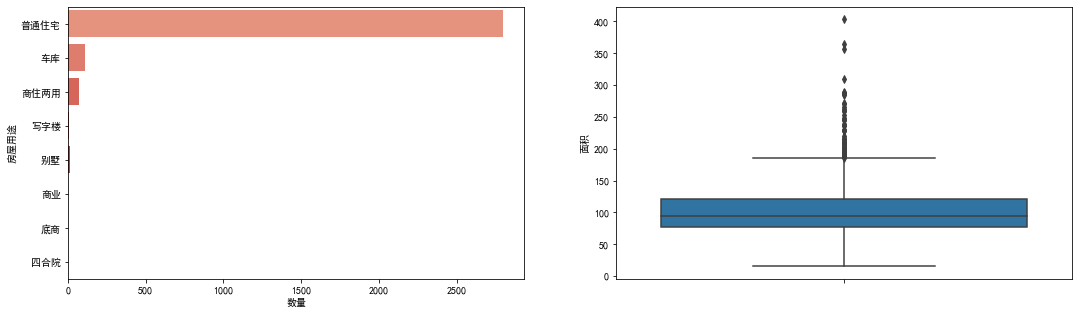

In [63]:
f, [ax1,ax2] = plt.subplots(1, 2, figsize=(18, 5))
sns.countplot(data=raw_data,y='usage',palette='Reds_d',ax=ax1)
ax1.set_ylabel('房屋用途')
ax1.set_xlabel('数量')

data = raw_data[(raw_data['usage'] == '普通住宅') | (raw_data['usage'] == '商住两用') |
                (raw_data['usage'] == '四合院')]
sns.boxplot(data=data,y='area',ax=ax2)
ax2.set_ylabel('面积')

In [70]:
data[data['area']>400]

,area,building,direction,elevator,floor,garden,heating,_id,layout,region,renovation,stairway,structure,totalPrice,type,unitPrice,usage,year
2167,403.44,NaN,南 北,NaN,低楼层 (共3层),长安,NaN,101117604283,5室3厅1厨4卫,长安,简装,一梯一户,未知结构,1150.0,复式,28505.0,普通住宅,满两年


手动查询发现，因为信息登记不规范，id:101117604283仍是独栋别墅，单独去除

In [82]:
data.drop(data.query('_id ==101117604283').index,inplace=True)
data[data['area']>400]

C:\Users\19317\AppData\Local\Temp\ipykernel_16420\3444213790.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(data.query('_id ==101117604283').index,inplace=True)


,area,building,direction,elevator,floor,garden,heating,_id,layout,region,renovation,stairway,structure,totalPrice,type,unitPrice,usage,year


In [53]:
data['direction'].value_counts(dropna=False)

南 北            1263
南               775
北               150
东南              124
西南               98
东                87
西                74
西北               45
东北               36
北 南              32
东 南              25
东 西              23
南 西              17
东 北              14
东南 南             14
西 北              14
南 西南             10
南 西 北            10
东 南 北             8
西 南               5
南 东南              4
东 东南              4
北 东北              3
南 西北              3
南 北 西             2
东南 北              2
东 南 西             2
西 南 北             2
西南 西              2
东 西 北             2
东南 东              2
西北 东北             1
北 东               1
南 北 东南            1
西北 北              1
西 东               1
东南 西              1
东 东南 南 西南 西       1
北 东 西             1
东南 西南             1
东 东南 北            1
东 东南 南            1
南 东               1
北 西北              1
西南 北              1
东南 南 北            1
Name: direction, dtype: int64

In [52]:
data['building'].value_counts(dropna=False)

板塔结合    1356
板楼       941
塔楼       430
NaN      126
平房        14
Name: building, dtype: int64

### `layout`
链家的信息登记较规范，格式为“X室X厅X厨X卫”，无缺失值\
因此用正则表达式提取即可

In [84]:
data[['layout_room','layout_hall','layout_kitchen','layout_bathroom']]=\
    data['layout'].str.extract(r'(\d*)室(\d*)厅+(\d*)厨(\d*)卫+').astype('int')

C:\Users\19317\AppData\Local\Temp\ipykernel_16420\3977827848.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[['layout_room','layout_hall','layout_kitchen','layout_bathroom']]=\
C:\Users\19317\AppData\Local\Temp\ipykernel_16420\3977827848.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[['layout_room','layout_hall','layout_kitchen','layout_bathroom']]=\
C:\Users\19317\AppData\Local\Temp\ipykernel_16420\3977827848.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

### `elevator`
缺失值处理\
&ensp;&ensp;&ensp;&ensp;填充&ensp;&ensp;依据：根据房屋所在楼的高度，若高于6层一般会加装电梯\
哑变量处理

In [17]:
data['building_height'] = data['floor'].str.extract(r'共(\d+)层').astype('int')
data.loc[(data['elevator'].isnull()) & (data['building_height'] > 6),
         'elevator'] = '有'
data.loc[(data['elevator'].isnull()) & (data['building_height'] > 6),
         'elevator'] = '无'
data['elevator'] = data['elevator'].apply(lambda x: 1 if x == '有' else 0)
data['elevator'].value_counts()

C:\Users\19317\AppData\Local\Temp\ipykernel_16420\3322760788.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['building_height'] = data['floor'].str.extract(r'共(\d+)层').astype('int')
C:\Users\19317\AppData\Local\Temp\ipykernel_16420\3322760788.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['elevator'] = data['elevator'].apply(lambda x: 1 if x == '有' else 0)


1    2530
0     337
Name: elevator, dtype: int64

## Insight

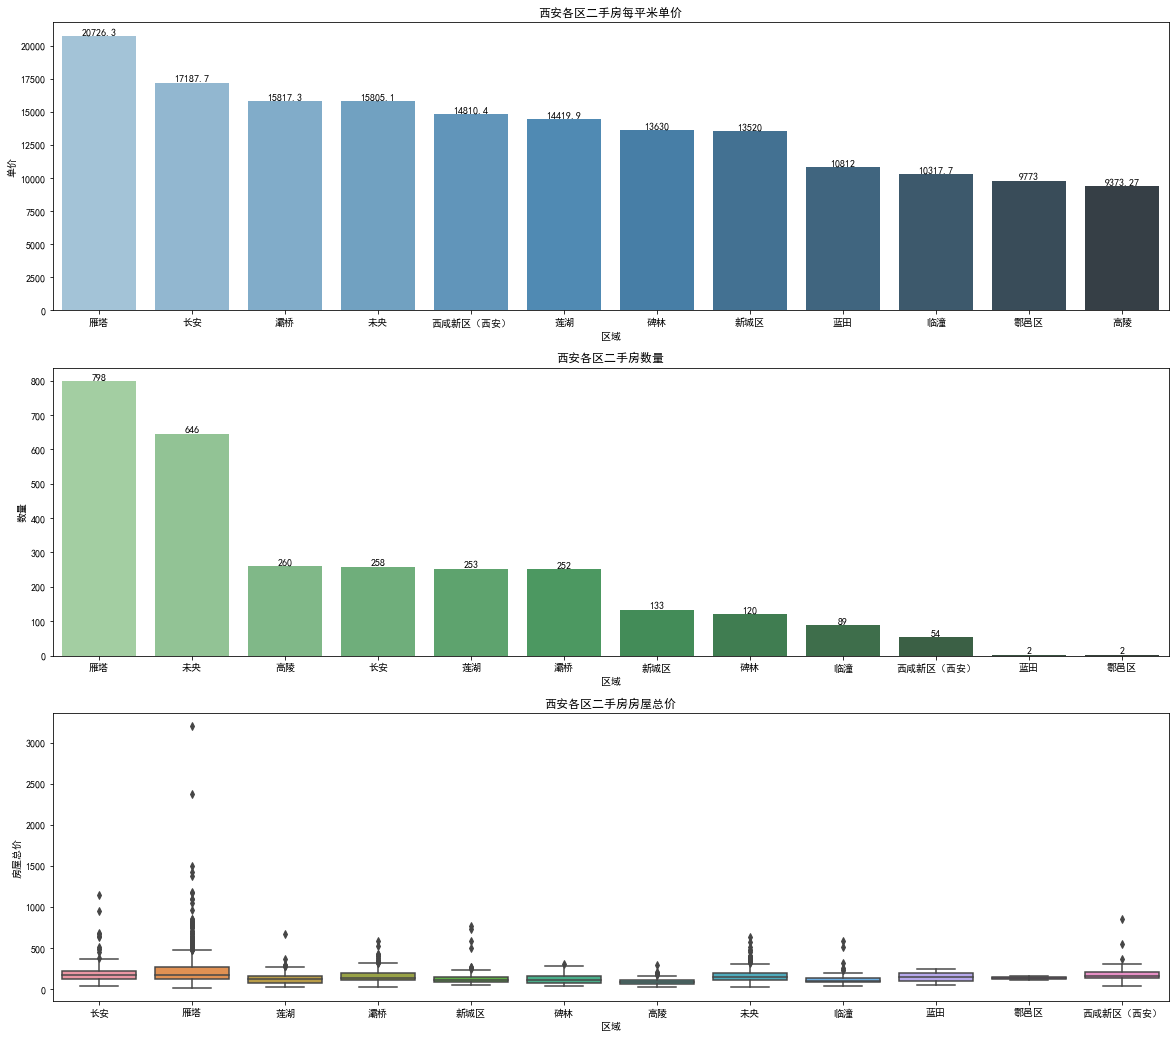

In [26]:
regionPrice=data.groupby('region')['unitPrice']\
    .mean().sort_values(ascending=False).to_frame().reset_index()
regionCount=data.groupby('region')['_id']\
    .count().sort_values(ascending=False).to_frame().reset_index()

f, [ax1, ax2, ax3] = plt.subplots(3, 1, figsize=(20, 18))
bar1=sns.barplot(x='region',y='unitPrice',palette="Blues_d",\
    data=regionPrice,ax=ax1)
ax1.bar_label(bar1.containers[0])
ax1.set_xlabel('区域')
ax1.set_ylabel('单价')
ax1.set_title('西安各区二手房每平米单价')

bar2=sns.barplot(x='region',y='_id',palette="Greens_d",\
    data=regionCount,ax=ax2)
ax2.bar_label(bar2.containers[0])
ax2.set_xlabel('区域')
ax2.set_ylabel('数量')
ax2.set_title('西安各区二手房数量')

sns.boxplot(x='region', y='totalPrice', data=data, ax=ax3)
ax3.set_xlabel('区域')
ax3.set_ylabel('房屋总价')
ax3.set_title('西安各区二手房房屋总价')

plt.show()